In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
import jax.numpy as jnp
from jax import grad, jit, vmap
from torchvision.datasets import MNIST
from jax import random
from torch.utils.data import DataLoader,random_split


In [ ]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [784, 512, 512, 10]
step_size = 0.01
num_epochs = 10
batch_size = 128
n_targets = 10
params = init_network_params(layer_sizes, random.PRNGKey(0))

In [ ]:
from jax.scipy.special import logsumexp

def relu(x):
  return jnp.maximum(0, x)

def predict(params, image):
  # per-example predictions
  activations = image
  for w, b in params[:-1]:
    outputs = jnp.dot(w, activations) + b
    activations = relu(outputs)
  
  final_w, final_b = params[-1]
  logits = jnp.dot(final_w, activations) + final_b
  return logits - logsumexp(logits)

In [ ]:
# This works on single examples
random_flattened_image = random.normal(random.PRNGKey(1), (28 * 28,))
preds = predict(params, random_flattened_image)
print(preds.shape)

(10,)


In [ ]:
# Doesn't work with a batch
random_flattened_images = random.normal(random.PRNGKey(1), (10, 28 * 28))
try:
  preds = predict(params, random_flattened_images)
except TypeError:
  print('Invalid shapes!')

# Let's upgrade it to handle batches using `vmap`

# Make a batched version of the `predict` function
batched_predict = vmap(predict, in_axes=(None, 0))

# `batched_predict` has the same call signature as `predict`
batched_preds = batched_predict(params, random_flattened_images)
print(batched_preds.shape)

Invalid shapes!
(10, 10)


In [ ]:
def one_hot(x, k, dtype=jnp.float32):
  """Create a one-hot encoding of x of size k."""
  return jnp.array(x[:, None] == jnp.arange(k), dtype)
  
def accuracy(params, images, targets):
  target_class = jnp.argmax(targets, axis=1)
  predicted_class = jnp.argmax(batched_predict(params, images), axis=1)
  return jnp.mean(predicted_class == target_class)

def loss(params, images, targets):
  preds = batched_predict(params, images)
  return -jnp.mean(preds * targets)

@jit
def update(params, x, y):
  grads = grad(loss)(params, x, y)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

In [ ]:
import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
tf.config.set_visible_devices([], device_type='GPU')

import tensorflow_datasets as tfds
def custom_collate_fn(batch):
   transposed_data=list(zip(*batch))
   
   labels=np.array(transposed_data[1])
   imgs=np.array(transposed_data[0])
 
   return imgs,labels
data_dir = '/tmp/tfds'

# Fetch full datasets for evaluation
# tfds.load returns tf.Tensors (or tf.data.Datasets if batch_size != -1)
# You can convert them to NumPy arrays (or iterables of NumPy arrays) with tfds.dataset_as_numpy
mnist_data, info = tfds.load(name="mnist", batch_size=-1, data_dir=data_dir, with_info=True)
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data['train'], mnist_data['test']
num_labels = info.features['label'].num_classes
h, w, c = info.features['image'].shape
num_pixels = h * w * c

trainloader= DataLoader(train_data, batch_size, shuffle=True, collate_fn=custom_collate_fn,drop_last=True)
testloader= DataLoader(test_data, batch_size, shuffle=False, collate_fn=custom_collate_fn,drop_last=True)
# Full train set
train_images, train_labels = train_data['image'], train_data['label']
train_images = jnp.reshape(train_images, (len(train_images), num_pixels))
train_labels = one_hot(train_labels, num_labels)

# Full test set
test_images, test_labels = test_data['image'], test_data['label']
test_images = jnp.reshape(test_images, (len(test_images), num_pixels))
test_labels = one_hot(test_labels, num_labels)

In [ ]:
print('Train:', train_images.shape, train_labels.shape)
print('Test:', test_images.shape, test_labels.shape)

Train: (60000, 784) (60000, 10)
Test: (10000, 784) (10000, 10)


In [ ]:
model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.BatchNorm2d(256),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))


In [ ]:
device=torch.device("cuda:0" if torch.cuda.is_available else "cpu")
model.to(device)

loss_fn=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

In [ ]:
train_losses=[]
train_accu=[]

def train(epoch):
  print('\nEpoch : %d'%epoch)
  
  model.train()

  running_loss=0
  correct=0
  total=0

  for data in tqdm(trainloader):
    
    inputs,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(inputs)
    
    loss=loss_fn(outputs,labels)
    
    #Replaces pow(2.0) with abs() for L1 regularization
    
    l2_lambda = 0.001
    l2_norm = sum(p.pow(2.0).sum()
                  for p in model.parameters())

    loss = loss + l2_lambda * l2_norm
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  train_loss=running_loss/len(trainloader)
  accu=100.*correct/total
  
  train_accu.append(accu)
  train_losses.append(train_loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))

In [ ]:
eval_losses=[]
eval_accu=[]

def test(epoch):
  model.eval()

  running_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(test_data):
      images,labels=data[0].to(device),data[1].to(device)
      
      outputs=model(images)

      loss= loss_fn(outputs,labels)
      running_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  test_loss=running_loss/len(test_data)
  accu=100.*correct/total

  eval_losses.append(test_loss)
  eval_accu.append(accu)

  print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 



In [ ]:
import time

def get_train_batches():
  # as_supervised=True gives us the (image, label) as a tuple instead of a dict
  ds = tfds.load(name='mnist', split='train', as_supervised=True, data_dir=data_dir)
  # You can build up an arbitrary tf.data input pipeline
  ds = ds.batch(batch_size).prefetch(1)
  # tfds.dataset_as_numpy converts the tf.data.Dataset into an iterable of NumPy arrays
  return tfds.as_numpy(ds)

for epoch in range(num_epochs):
  start_time = time.time()
  for x, y in get_train_batches():
    x = jnp.reshape(x, (len(x), num_pixels))
    y = one_hot(y, num_labels)
    params = update(params, x, y)
  epoch_time = time.time() - start_time

  train_acc = accuracy(params, train_images, train_labels)
  test_acc = accuracy(params, test_images, test_labels)
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Training set accuracy {}".format(train_acc))
  print("Test set accuracy {}".format(test_acc))

Epoch 0 in 6.39 sec
Training set accuracy 0.9974666833877563
Test set accuracy 0.9788999557495117
Epoch 1 in 6.23 sec
Training set accuracy 0.9977499842643738
Test set accuracy 0.9789999723434448
Epoch 2 in 6.24 sec
Training set accuracy 0.9979333281517029
Test set accuracy 0.9790999889373779
Epoch 3 in 7.23 sec
Training set accuracy 0.9980999827384949
Test set accuracy 0.9790999889373779
Epoch 4 in 6.19 sec
Training set accuracy 0.9982500076293945
Test set accuracy 0.9791999459266663
Epoch 5 in 6.28 sec
Training set accuracy 0.9984000325202942
Test set accuracy 0.9790999889373779
Epoch 6 in 6.14 sec
Training set accuracy 0.9984666705131531
Test set accuracy 0.9790999889373779
Epoch 7 in 6.19 sec
Training set accuracy 0.9986000061035156
Test set accuracy 0.9792999625205994
Epoch 8 in 6.15 sec
Training set accuracy 0.9986833333969116
Test set accuracy 0.9789999723434448
Epoch 9 in 6.30 sec
Training set accuracy 0.9988166689872742
Test set accuracy 0.9790999889373779


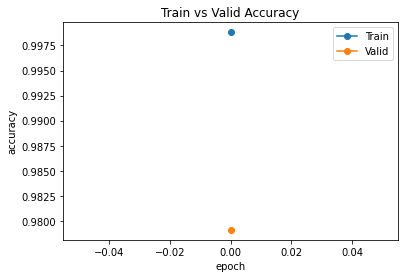

In [ ]:
#plot accuracy

plt.plot(train_acc,'-o')
plt.plot(test_acc,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

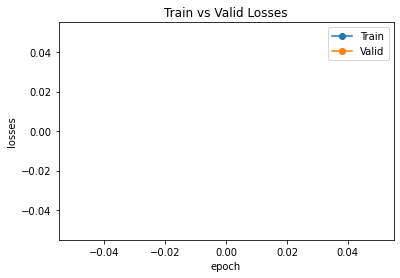

In [ ]:
#plot losses

plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()